In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
helper_path = "../code/"
sys.path.insert(0, helper_path)

In [ ]:
from New_MissingValue import MissingValue

In [ ]:
# relative path
data_path = "../data/"
data_file_list = ["train.csv","test.csv"]

In [ ]:
# load data
data_train = pd.read_csv(data_path + data_file_list[0])
data_test = pd.read_csv(data_path + data_file_list[1])

# data info
print(f'Training text file: {data_train.shape[0]} rows; {data_train.shape[1]} columns')
print(f'Testing text file: {data_test.shape[0]} rows; {data_test.shape[1]} columns')
data_train.head()

In [ ]:
# check if NaNs exist in training data, and acquire their locations
missing_value_finder_train = MissingValue(data_train)
missing_value_finder_train.missing_value_summary(verbose=True)
missing_value_finder_train.missing_value_enumerator()

In [ ]:
# drop this missing row
for obj in missing_value_finder_train.na_index:
    data_train = data_train.drop([obj])

In [ ]:
# check again
missing_value_finder_train = MissingValue(data_train)
missing_value_finder_train.missing_value_summary(verbose=True)

In [ ]:
data_train.to_csv('../data/train_no_missingValue.csv')

In [ ]:
# check if NaNs exist in test data, and acquire their locations
missing_value_finder_test = MissingValue(data_test)
missing_value_finder_test.missing_value_summary(verbose=True)

Note:
- Missing value check & elimination finished 

# Data Classification

- Classify the data by their features, and save them into separate csv files, named "Positive.csv", "Negative.csv" and "Neutral.csv"

In [ ]:
def SentiSeparation(data):
    Positive=data[data['sentiment']=='positive']
    Negative=data[data['sentiment']=='negative']
    Neutral=data[data['sentiment']=='neutral']
    Positive.to_csv(r'../data/Positive.csv')
    Negative.to_csv(r'../data/Negative.csv')
    Neutral.to_csv(r'../data/Neutral.csv')

In [ ]:
SentiSeparation(data_train)

# Data Cleaning

Since the data set is too large, running through all the data may take too long. Therefore, only data with feature "positive" is tested at this time.

In [2]:
process_path = "../code/"
sys.path.insert(0, process_path)

In [3]:
from TextPreprocessing import *
from StaAnalysis import StaA
import nltk

In [ ]:
Positive=pd.read_csv("../data/Positive/Positive.csv")
Positive=pd.DataFrame(Positive)
Positive.head()

In [ ]:
Negative=pd.read_csv("../data/Negative/Negative.csv")
Negative=pd.DataFrame(Negative)
Negative.head()

In [ ]:
Neutral=pd.read_csv("../data/Neutral/Neutral.csv")
Neutral=pd.DataFrame(Neutral)
Neutral.head()

def process_to_csv(process_df, feature, clean_csv_path1):
    """ Ensemble method for processing multiple tweets in dataframe (df)
    Params:
        process_df: the df to be processed
        feature: feature (colunm) of the df, use 'text' or 'selected_text'
        clean_csv_path: directory of written out csv file
    Return:
        saved_csv: csv file save to clean_csv_path
    """
    # copy the processed df from original df 
    processed_df = process_df.copy()
    processed_df_tbused=process_df.copy()
    
    for i, tweet in enumerate(process_df[feature]):
        if type(tweet) == str:
            processer = TweetPreprocess(tweet)
        else:
            raise Exception('The tweet must be str!')
            
        # call the processer class 
        clean_tweet_both = processer.process_tweet()
        clean_tweet=clean_tweet_both
        processed_df[feature][i] = clean_tweet
        
    # save as a csv file
    
    processed_df.to_csv(clean_csv_path1)
    return processed_df_tbused


In [ ]:
# saving path of the cleaned data
save1='../data/Negative_clean_data.csv'
# featured data to be cleaned
feature='selected_text'
# apply the previous function
selected_text=process_to_csv(Negative,feature,save1)
selected_text.head()

In [ ]:
# saving path of the cleaned data
save1='../data/Neutral_clean_data.csv'
# featured data to be cleaned
feature='selected_text'
# apply the previous function
selected_text=process_to_csv(Neutral,feature,save1)
selected_text.head()

In [ ]:
# saving path of the cleaned data
save1='../data/Positive/Positive_clean_data.csv'
#save2='../data/Positive/Positive_clean_data_2bused.csv'
# featured data to be cleaned
feature='selected_text'
# apply the previous function
selected_text=process_to_csv(Positive,feature,save1)
selected_text.head()

# Preparation for Statistical Analysis -- Unigram/Multi-gram

Cleaned data are used to do statistical analysis. Due to the large size of the data to be processed, only first 50 sets of data are tested to verify the code.

In [4]:
from nltk.tokenize import word_tokenize
selected_text=pd.read_csv('../data/Positive/Positive_clean_data.csv')
selected_text=selected_text['selected_text'].apply(str)
split_selected_text=[]
split_selected_word=[]
for i in range(len(selected_text)):
    split_selected_text.append(word_tokenize(selected_text[i]))
    for j in split_selected_text[i]:
        split_selected_word.append(j)

check if unigram works, N=1

In [5]:
split_selected_text[:5]

[['good'], ['better'], ['had', 'an', 'awsome', 'salad'], ['fine'], ['thank']]

In [6]:
split_selected_word[:5]

['good', 'better', 'had', 'an', 'awsome']

In [7]:
# Timing the process of data clean
start=time.time()
uni_gram,uni_presence,uni_frequency,uni_number_unique_term,uniuni_gram=StaA.nGram(split_selected_word,split_selected_text,1)
uni_frequency,uni_presence,uni_rank=StaA.ranking(uni_frequency,uni_presence,uni_gram,'../data/Positive/uni_rank.csv')
end=time.time()
print(end-start)

Unigram text framework
8.830651044845581


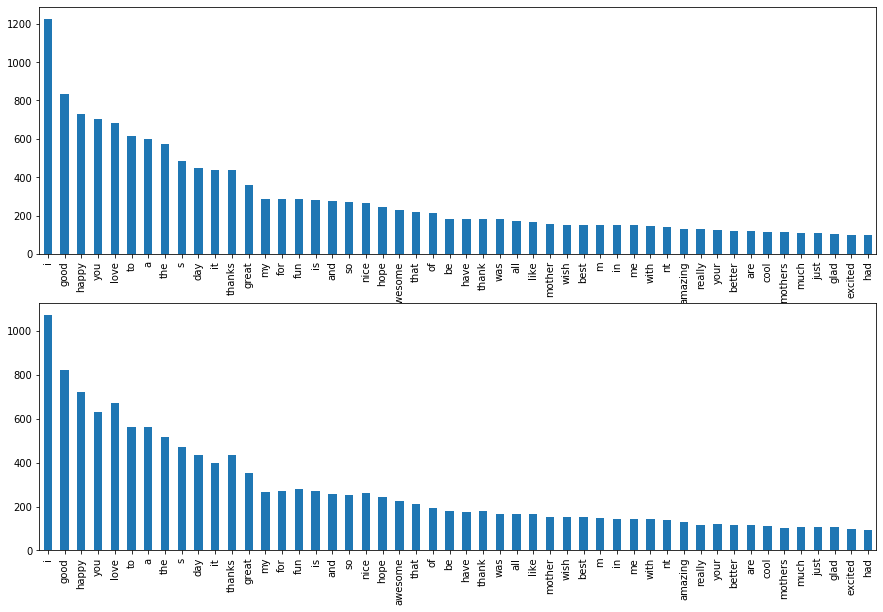

In [8]:
# high frequency word
plt.subplot(2,1,1)
uni_frequency.head(50).plot.bar(figsize=(15,10))
plt.subplot(2,1,2)
uni_presence.head(50).plot.bar(figsize=(15,10))

In [9]:
print(uni_presence)

i             1072.0
good           824.0
happy          722.0
you            632.0
love           670.0
               ...  
horses           1.0
victory          1.0
swimming         1.0
budget           1.0
gnimorning       1.0
Name: presence, Length: 3921, dtype: float64


In [10]:
print(uni_frequency)

i             1227
good           836
happy          729
you            703
love           683
              ... 
horses           1
victory          1
swimming         1
budget           1
gnimorning       1
Name: frequency, Length: 3921, dtype: int64


In [11]:
print(uni_rank)

            frequency  presence
i                1227    1072.0
good              836     824.0
happy             729     722.0
you               703     632.0
love              683     670.0
...               ...       ...
horses              1       1.0
victory             1       1.0
swimming            1       1.0
budget              1       1.0
gnimorning          1       1.0

[3921 rows x 2 columns]


In [12]:
start=time.time()
bi_gram,bi_presence,bi_frequency,bi_number_unique_term,bibi_gram=StaA.nGram(split_selected_word,split_selected_text,2)
bi_frequency,bi_presence,bi_rank=StaA.ranking(bi_frequency,bi_presence,bi_gram,'../data/Positive/bi_rank')
end=time.time()
print(end-start)

2-gram text frame work
27.182887077331543


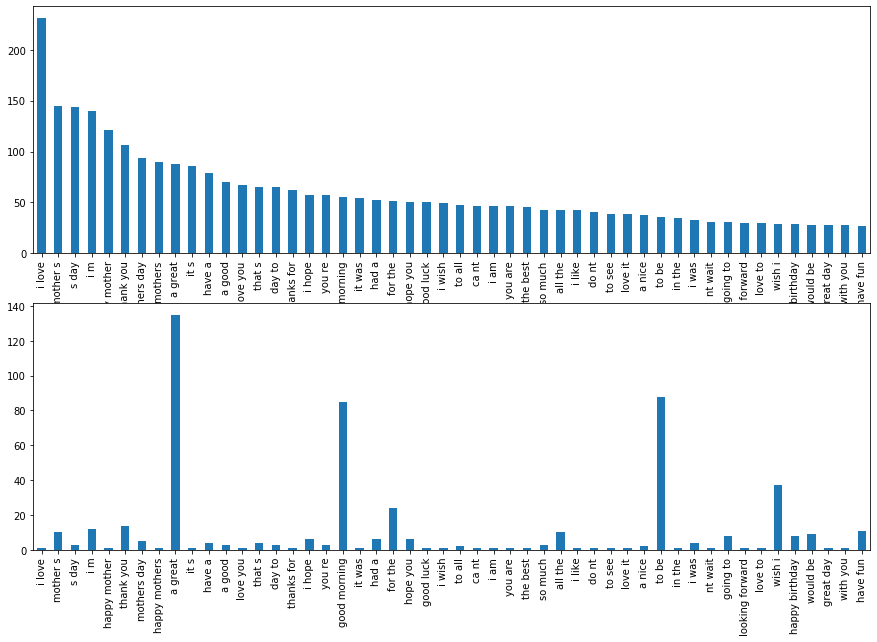

In [13]:
# high frequency word
plt.subplot(2,1,1)
bi_frequency.head(50).plot.bar(figsize=(15,10))
plt.subplot(2,1,2)
bi_presence.head(50).plot.bar(figsize=(15,10))

In [14]:
print(bi_frequency)

i love           231
mother s         145
s day            144
i m              140
happy mother     121
                ... 
of cool            1
forever enjoy      1
are in             1
heart ripped       1
really only        1
Name: frequency, Length: 12877, dtype: int64


In [15]:
print(bi_presence)

i love            1.0
mother s         10.0
s day             3.0
i m              12.0
happy mother      1.0
                 ... 
of cool           1.0
forever enjoy     1.0
are in            1.0
heart ripped      1.0
really only       1.0
Name: presence, Length: 12877, dtype: float64


In [16]:
print(bi_rank)

               frequency  presence
i love               231       1.0
mother s             145      10.0
s day                144       3.0
i m                  140      12.0
happy mother         121       1.0
...                  ...       ...
of cool                1       1.0
forever enjoy          1       1.0
are in                 1       1.0
heart ripped           1       1.0
really only            1       1.0

[12877 rows x 2 columns]


check if multi-gram works, N=4

In [17]:
start=time.time()
tri_gram,tri_presence,tri_frequency,tri_number_unique_term,tritri_gram=StaA.nGram(split_selected_word,split_selected_text,3)
tri_frequency,tri_presence,tri_rank=StaA.ranking(tri_frequency,tri_presence,tri_gram,'../data/Positive/tri_rank.csv')
end=time.time()
print(end-start)

3-gram text frame work
25.571311712265015


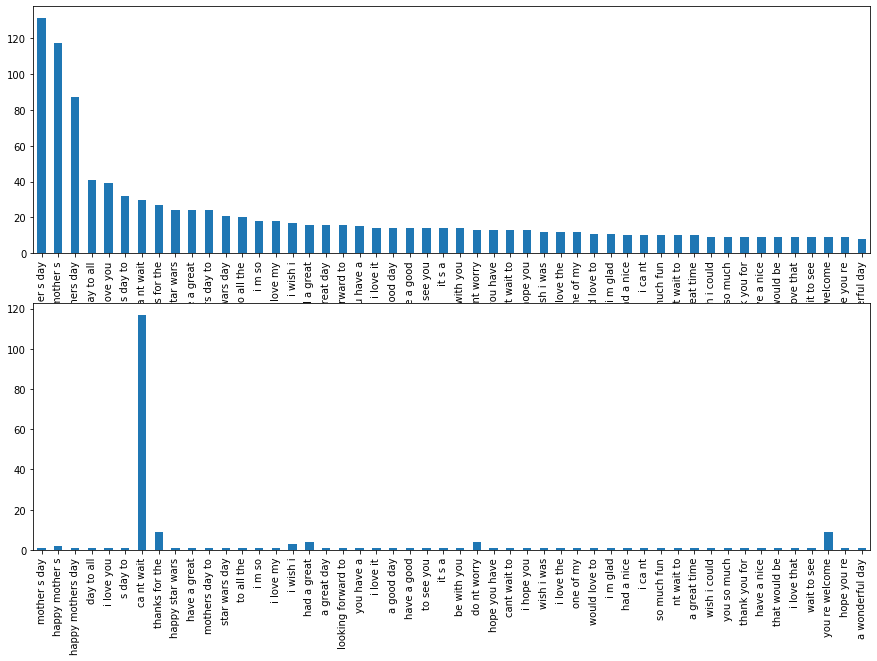

In [18]:
# high frequency word
plt.subplot(2,1,1)
tri_frequency.head(50).plot.bar(figsize=(15,10))
plt.subplot(2,1,2)
tri_presence.head(50).plot.bar(figsize=(15,10))

In [19]:
print(tri_frequency)

mother s day                131
happy mother s              117
happy mothers day            87
day to all                   41
i love you                   39
                           ... 
has just finished             1
gilbert amp sullivan          1
feeling away from             1
birthdayy please say          1
muchdeserved special day      1
Name: frequency, Length: 14708, dtype: int64


In [20]:
print(tri_presence)

mother s day                1.0
happy mother s              2.0
happy mothers day           1.0
day to all                  1.0
i love you                  1.0
                           ... 
has just finished           1.0
gilbert amp sullivan        1.0
feeling away from           1.0
birthdayy please say        1.0
muchdeserved special day    2.0
Name: presence, Length: 14708, dtype: float64


In [21]:
print(tri_rank)

                          frequency  presence
mother s day                    131       1.0
happy mother s                  117       2.0
happy mothers day                87       1.0
day to all                       41       1.0
i love you                       39       1.0
...                             ...       ...
has just finished                 1       1.0
gilbert amp sullivan              1       1.0
feeling away from                 1       1.0
birthdayy please say              1       1.0
muchdeserved special day          1       2.0

[14708 rows x 2 columns]


In [25]:
start=time.time()
tert_gram,tert_presence,tert_frequency,tert_number_unique_term,terttert_gram=StaA.nGram(split_selected_word,split_selected_text,4)
tert_frequency,tert_presence,tert_rank=StaA.ranking(tert_frequency,tert_presence,tert_gram,'../data/Positive/tert_rank.csv')
end=time.time()
print(end-start)

4-gram text frame work
21.51617407798767


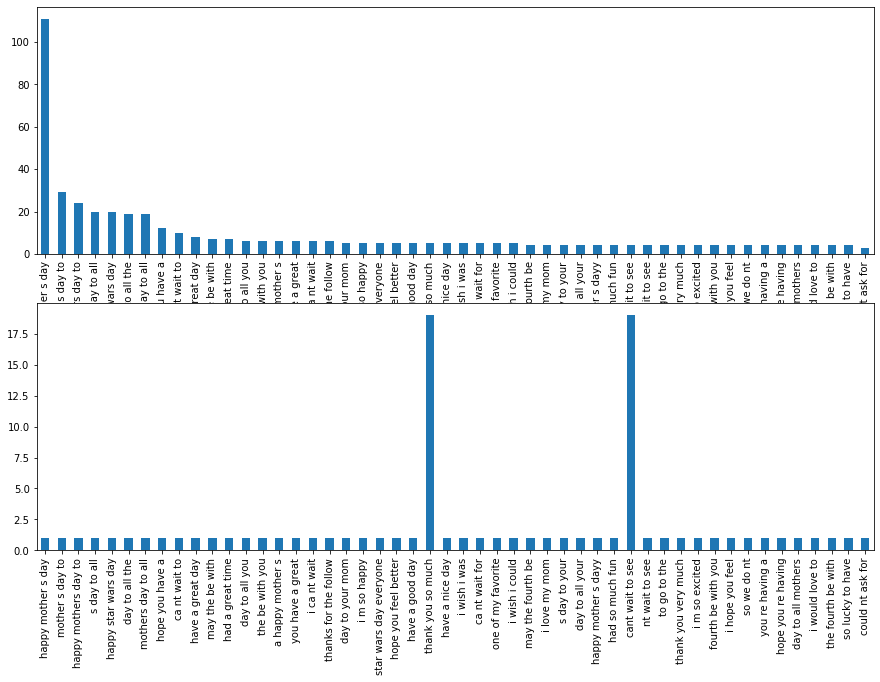

In [26]:
# high frequency word
plt.subplot(2,1,1)
tert_frequency.head(50).plot.bar(figsize=(15,10))
plt.subplot(2,1,2)
tert_presence.head(50).plot.bar(figsize=(15,10))

In [27]:
print(tert_frequency)

happy mother s day       111
mother s day to           29
happy mothers day to      24
s day to all              20
happy star wars day       20
                        ... 
must say that i            1
nt whine about bad         1
to all your wonderful      1
has got a degree           1
you happy star wars        1
Name: frequency, Length: 12986, dtype: int64


In [28]:
print(tert_presence)

happy mother s day       1.0
mother s day to          1.0
happy mothers day to     1.0
s day to all             1.0
happy star wars day      1.0
                        ... 
must say that i          1.0
nt whine about bad       1.0
to all your wonderful    1.0
has got a degree         1.0
you happy star wars      1.0
Name: presence, Length: 12986, dtype: float64


In [29]:
print(tert_rank)

                       frequency  presence
happy mother s day           111       1.0
mother s day to               29       1.0
happy mothers day to          24       1.0
s day to all                  20       1.0
happy star wars day           20       1.0
...                          ...       ...
must say that i                1       1.0
nt whine about bad             1       1.0
to all your wonderful          1       1.0
has got a degree               1       1.0
you happy star wars            1       1.0

[12986 rows x 2 columns]


# Numerify the Text Output of 'Sentiment'

In [ ]:
sentiment=pd.get_dummies(data_train['sentiment'])
print(sentiment)

Assigning sentiment information with values.

In [ ]:
from nltk import FreqDist
import pickle
import sys
import utils

In [ ]:
from collections import Counter

In [22]:
split_selected_text

[['good'],
 ['better'],
 ['had', 'an', 'awsome', 'salad'],
 ['fine'],
 ['thank'],
 ['have',
  'just',
  'bought',
  'a',
  'tv',
  'tuner',
  'for',
  'my',
  'laptop',
  'he',
  'he',
  'i',
  'deserve',
  'a',
  'present'],
 ['happy', 'birthday', 'little', 'sister', 'of', 'mine'],
 ['aaww', 'no', 'worries'],
 ['glad'],
 ['mp', 'me'],
 ['cute'],
 ['o',
  'quite',
  'like',
  'lily',
  'allen',
  'and',
  'her',
  'music',
  'to',
  'be',
  'honest'],
 ['i', 'm', 'soo', 'happy', 'de'],
 ['that', 'would', 'be', 'most', 'welcome'],
 ['happy'],
 ['aw', 'that', 's', 'cute'],
 ['so', 'good', 'glad', 'you', 'finally', 'got', 'to', 'see', 'them'],
 ['have', 'a', 'great', 'day', 'everyone'],
 ['today', 'seems', 'like', 'it', 'should', 'be', 'a', 'good', 'day'],
 ['love'],
 ['nice'],
 ['hall',
  'no',
  'i',
  'was',
  'gutted',
  'when',
  'he',
  'was',
  'nt',
  'lmao',
  'i',
  'think',
  'i',
  'm',
  'obsessed',
  'with',
  'him',
  'bahaha'],
 ['good', 'person'],
 ['hoping'],
 ['e', 'nic